## 11.3 Multidimensional Integrals

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ipywidgets

Many problems in physics involve average over many variables. For example:

- compute total energy (kinetic and potential) for ten interacting particles
- three velocity components and three position components
- *calculate* the average energy per particle
  - requires a $d=60$ dimensional integral
  - dividing each coordinate into $p$ intervals gives $p^{60}$ points to sum
  
Standard numerical method such as Simpson's rule are impractical for this example.

In Appendix 11A, it is shown for standard numerical techniques that if the error decreases as $n^{-a}$ for $d=1$, then the error decreases  as $n^{-a/d}$ in $d$ dimensions.

For Monte Carlo intergation methods the error decreases as $n^{-1/2}$ *independently* of the dimension of the integral.

Computational cost is proportional to $n$ for both classical numerical methods (e.g. Simpson's Rule) and Monte Carlo methods. When dimension is low, stick with standard integration techniques. For higher dimensional integrals, Monte Carlo methods are essential.

### 2-D Example

$$F = \int_R f(x,y) dx dy$$

Suppose the region $R$ is 

$$x^2 + y^2 \le 1$$

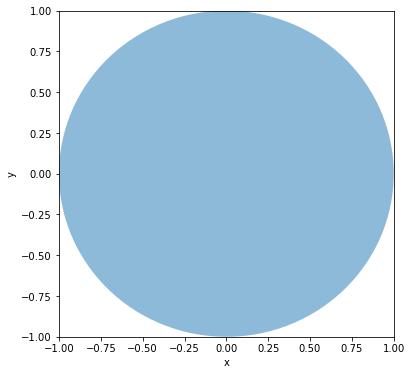

In [2]:
R = plt.Circle((0,0), 1, alpha=0.5)
fig, ax = plt.subplots(figsize=(6, 6))

ax.add_patch(R)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

We want to integrate

$$ f(x) = x^2 + 6 x y + y^2 $$

over this region.

#### Midpoint approximation

A classical way would be to divide the rectangle that encloses $R$ into a number of squares of length $h$.

If the bounding rectangle is $[x_a, x_b] \times [y_a, y_b]$ then the total number of squares is given by

$$ n_x = \frac{(x_b - x_a)}{h}$$

and

$$ n_y = \frac{(y_b - y_a)}{h}$$


In [87]:
@ipywidgets.interact(n=(4, 400),
                     show_points=ipywidgets.Checkbox(value=False,
                                 description='Show $x_i, y_i$ (disabled for $n > 40$)', indent=True),
                     show_grid=ipywidgets.Checkbox(value=True,
                                 description='Grid (disabled for $n>100$)', indent=True)
)
def plot_midpointapprox(n=8, show_grid=True, show_points=False, show_integral=False):
    xa = -1
    xb = 1
    ya = -1
    yb = 1
    h = (xb-xa)/n
    h = (yb-ya)/n
    
    f = lambda x, y: x**2 + 6*x*y + y**2
    
    nx = int((xb-xa)/h)
    ny = int((yb-ya)/h)

    R = plt.Circle((0,0), 1, alpha=0.5)
    fig, ax = plt.subplots(figsize=(6, 6))

    ax.add_patch(R)

    if show_grid and n <= 100:
        plt.grid(color='gray', which='minor', linestyle='-')
        plt.grid(color='gray', which='major', linestyle='-')

        ax.xaxis.set_ticks(np.arange(xa, xb, h), minor=True)
        ax.xaxis.set_ticks(np.arange(xa, xb+h, nx//4*h))
        ax.yaxis.set_ticks(np.arange(ya, yb, h), minor=True)
        ax.yaxis.set_ticks(np.arange(ya, yb+h, ny//4*h))

    x = xa + (np.arange(1, nx+1) - 1/2)*h
    y = ya + (np.arange(1, ny+1) - 1/2)*h

    F = 0
    for i in range(nx):
        for j in range(ny):
            if x[i]**2 + y[j]**2 <= 1:
                F += f(x[i], y[j]) * h**2
                color = 'k'
            else:
                color = 'w'

            if show_points and n <= 40:
                plt.plot(x[i], y[j], 'o', markersize=4, color=color, mec='k')

    
    
    if show_integral:
        plt.text(0, -0.5,

                 '$\\int_R x^2 + 6 x y + y^2 \\approx {:.4f}$'.format(F), 
                 horizontalalignment='center',
                 bbox=dict(facecolor='white'),
                 fontsize=12)
        
    plt.title(f'$h = {h:.2f}$,  $n^2 = {nx*ny:.0f}$')
    plt.xlim(xa, xb)
    plt.ylim(ya, yb)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

interactive(children=(IntSlider(value=8, description='n', max=400, min=4), Checkbox(value=True, description='G…

The midpoint approximation estimates the integral by

$$ F \approx \sum_{i=1}^{n_x} \sum_{j=1}^{n_y} f(x_i, y_i) H(x_i, y_j) h^2 $$

where $x_i = x_a + (i - \frac{1}{2})h$,  $y_j = y_a + (j - \frac{1}{2})h$ and the (Heaviside) function $H(x,y)=1$ if $(x,y)$ is in $R$ and equals $0$ otherwise.

In [53]:
import numba

In [54]:
@numba.jit
def midpointapprox(h):
    xa = -1
    xb = 1
    ya = -1
    yb = 1
    
    f = lambda x, y: x**2 + 6*x*y + y**2
    
    nx = int((xb-xa)/h)
    ny = int((yb-ya)/h)

    x = xa + (np.arange(1, nx+1) - 1/2)*h
    y = ya + (np.arange(1, ny+1) - 1/2)*h

    F = 0
    for i in range(nx):
        for j in range(ny):
            if x[i]**2 + y[j]**2 <= 1:
                F += f(x[i], y[j]) * h**2
    
    return F

In [79]:
%%time
midpointapprox.py_func(0.0025)

CPU times: user 1.21 s, sys: 0 ns, total: 1.21 s
Wall time: 1.21 s


1.5707785280468363

In [80]:
%%time
midpointapprox(0.0025)

CPU times: user 563 µs, sys: 0 ns, total: 563 µs
Wall time: 565 µs


1.5707785280468363

### Monte Carlo method

A simple Monte Carlo method would be chosen the $n$ points $(x_i, y_i)$ at random within the retangle.

The estimate of the integral is then

$$ F_n = \frac{A}{n} \sum_{i=1}^n f(x_i, y_i) H(x_i, y_i) $$

where $ A$ is the area of the rectangle.  This represents the area of the region $R$ multiplied by the average value of $f(x,y)$ in $R$.

In [161]:
@ipywidgets.interact(n=(100, 200000),
                     show_points=ipywidgets.Checkbox(value=True,
                                 description='Show points', indent=True),
)
def plot_montecarlo(n=500, show_points=False, show_integral=True):
    xa = -1
    xb = 1
    ya = -1
    yb = 1
    h = (xb-xa)/n
    h = (yb-ya)/n
    
    f = lambda x, y: x**2 + 6*x*y + y**2
    
    R = plt.Circle((0,0), 1, alpha=0.5)
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.add_patch(R)

    ## sample mean method
    F = 0
    xi = np.random.rand(n)*(xb-xa)+xa
    yi = np.random.rand(n)*(yb-ya)+ya
    hit = xi**2 + yi**2 <= 1
    A = (xb - xa)*(yb-ya)
    F = A/n * np.sum(f(xi[hit], yi[hit]))
    
    if show_points:
        nothit = np.logical_not(hit)
        
        plt.plot(xi[hit], yi[hit], 'x', color='g')
        plt.plot(xi[nothit], yi[nothit], 'x', color='r')
            
    if show_integral:
        plt.text(0, -0.5,
                 '$\\int_R x^2 + 6 x y + y^2 \\approx {:.4f}$'.format(F), 
                 horizontalalignment='center',
                 bbox=dict(facecolor='white'),
                 fontsize=12)
        
    plt.title(f'n = {n}')
    plt.xlim(xa, xb)
    plt.ylim(ya, yb)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

interactive(children=(IntSlider(value=500, description='n', max=200000, min=100), Checkbox(value=True, descrip…

In [154]:
def montecarlo(n):
    xa = -1
    xb = 1
    ya = -1
    yb = 1
    h = (xb-xa)/n
    h = (yb-ya)/n
    
    f = lambda x, y: x**2 + 6*x*y + y**2
    
    ## sample mean method
    F = 0
    xi = np.random.rand(n)*(xb-xa)+xa
    yi = np.random.rand(n)*(yb-ya)+ya
    hit = xi**2 + yi**2 <= 1
    A = (xb - xa)*(yb-ya)
    F = A/n * np.sum(f(xi[hit], yi[hit]))
    
    return F

In [155]:
#@numba.jit
def montecarlo_explicit(n):
    xa = -1
    xb = 1
    ya = -1
    yb = 1
    h = (xb-xa)/n
    h = (yb-ya)/n
    
    f = lambda x, y: x**2 + 6*x*y + y**2
    
    ## sample mean method
    F = 0
    for i in range(n):
        xi = np.random.rand()*(xb-xa)+xa
        yi = np.random.rand()*(yb-ya)+ya
        hit = xi**2 + yi**2 <= 1
        if hit:
            F += f(xi, yi)
    
    A = (xb - xa)*(yb-ya)
    F = A/n * F
    
    return F

In [156]:
%%time
montecarlo(200000)

CPU times: user 6.97 ms, sys: 0 ns, total: 6.97 ms
Wall time: 5.8 ms


1.5718499536251234

In [157]:
%%time
montecarlo_explicit(200000)

CPU times: user 189 ms, sys: 0 ns, total: 189 ms
Wall time: 188 ms


1.586432474571262

### Volume of a hypersphere

> **Problem 11.9** Volume of a hypersphere
>
> a. The interior of a $d$-dimensional hypersphere of unit radius is defined by the condition $x_1^2+x_2^2+\cdots+x_d^2 \le 1$. Write a program that finds the volume of a hypersphere using the midpoint approximation. If you are clever, you can write a program that does any dimension using a recursive method. Test your program for $d=2$ and $d=3$, and then find the volume for $d=4$ and $d=5$. Begin with $h= 0.2$, and decrease $h$ until your results do not change by more than 1%.
> 
> b. Repeat part (a) using a Monte Carlo method. For each value of $n$, repeat the calculation several times to obtain a rough estimate of the random error. Is your program applicable for any $d$ easier to write than in part (a)?